In [2]:
import torch
import numpy as np

In [9]:
from transformers import AutoTokenizer, AutoModelForCausalLM, AutoConfig, BitsAndBytesConfig
tokenizer = AutoTokenizer.from_pretrained("/raid_sdd/whz/model/llava_1_5", use_fast=False)

/raid_sdb/home/whz/miniforge3/envs/halle/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
path = "/home/whz/code/HallE/visual_attn/attn_matrix/"

In [ ]:
load_attn = np.load(path+"test1_attn.npy")[0]
output_ids = np.load(path+"test1_output_ids.npy")[0]
input_ids = np.load(path+"test1_input_ids.npy")[0]

In [20]:
load_attn.shape, input_ids.shape, output_ids.shape

((32, 761, 761), (52,), (187,))

In [27]:
input_token_len = input_ids.shape[0]
n_diff_input_output = (input_ids != output_ids[ :input_token_len]).sum().item()
output_text = tokenizer.decode(output_ids[input_token_len:], skip_special_tokens=True)
print(output_text)

The image features a man wearing a red helmet and riding a motorcycle on a dirt road. He is sitting on the motorcycle, which is parked on the side of the road. The man appears to be enjoying his ride, possibly exploring the countryside or taking a break from his journey.

There are several other people in the scene, some of them standing or walking nearby. A backpack can be seen placed on the ground, possibly belonging to one of the people in the area. The overall atmosphere of the scene suggests a leisurely outdoor activity or a group of friends spending time together.


In [39]:
sys_len = 35
image_len = 1
instruction_len = input_token_len-sys_len-image_len
instruction_len
# input_ids[:36]

16

In [40]:
761-35-576-16

134

# 32 head  取平均，整体attn

In [177]:
# 32 个 head 取平均
mean_attn = np.mean(load_attn, axis=0, keepdims=True)[0]
# mean_attn = load_attn[0]
mean_attn.shape

(761, 761)

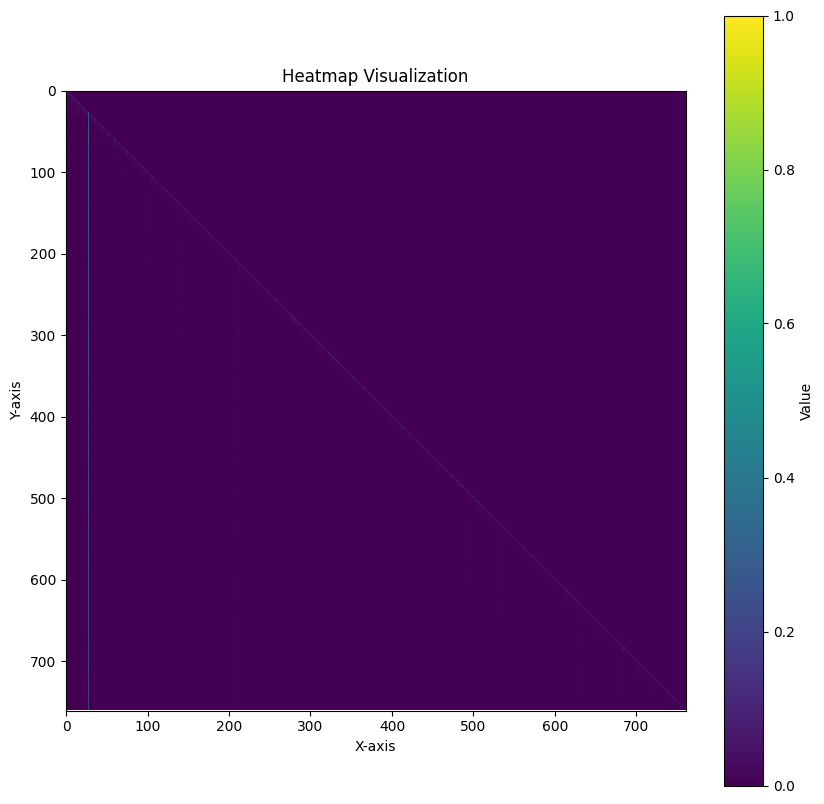

In [178]:
import matplotlib.pyplot as plt
import numpy as np

# 假设这是你的矩阵 (761, 761)
matrix = mean_attn

# 可视化热力图
plt.figure(figsize=(10, 10))           # 设置画布大小
plt.imshow(matrix, cmap='viridis')    # 使用 imshow 创建热力图，选择一个颜色映射，比如 'viridis'
plt.colorbar(label="Value")           # 添加颜色条，表示矩阵值的范围和意义
plt.title("Heatmap Visualization")    # 添加标题
plt.xlabel("X-axis")                  # 添加 X 轴标签
plt.ylabel("Y-axis")                  # 添加 Y 轴标签
plt.show()                            # 显示热力图

In [179]:
img_emb_len = 576
tmp_ans_len = 20
sys_col = mean_attn[:sys_len, :] # (35,761)
img_col = mean_attn[sys_len:sys_len+img_emb_len,:] # (576, 761)
ans_col = mean_attn[sys_len+img_emb_len: sys_len+img_emb_len+tmp_ans_len , :] #  (150, 761)
# mean_img_col = np.mean(img_col, axis=0, keepdims=True)
mean_img_col = np.max(img_col, axis=0, keepdims=True)
new_col = np.vstack([sys_col, mean_img_col, ans_col])
print(sys_col.shape, img_col.shape, ans_col.shape, mean_img_col.shape, new_col.shape)

sys_line = new_col[:, :sys_len]
img_line = new_col[:, sys_len:sys_len+img_emb_len]
ans_line = new_col[:, sys_len+img_emb_len: sys_len+img_emb_len+tmp_ans_len ]
# mean_img_line = np.mean(img_line, axis=1, keepdims=True)
mean_img_line = np.max(img_line, axis=1, keepdims=True)
new_matrix = np.hstack([sys_line, mean_img_line, ans_line])
print(sys_line.shape, img_line.shape, ans_line.shape, mean_img_line.shape, new_matrix.shape)

left = output_ids[:sys_len]
right = output_ids[sys_len + 1: sys_len + 1 +tmp_ans_len]
tmp = np.hstack((left, right))
print(len(tmp))
tmp_ans_text = tokenizer.decode(tmp)

charactor_lst = [tokenizer.decode(_) for _ in left] + ["<img>"] + [tokenizer.decode(_) for _ in right]
print(len(charactor_lst))
print(tmp_ans_text)

(35, 761) (576, 761) (20, 761) (1, 761) (56, 761)
(56, 35) (56, 576) (56, 20) (56, 1) (56, 56)
55
56
<s> A chat between a curious user and an artificial intelligence assistant. The assistant gives helpful, detailed, and polite answers to the user's questions. USER:  
Describe this image as detailed as possible. ASSISTANT: The image features a


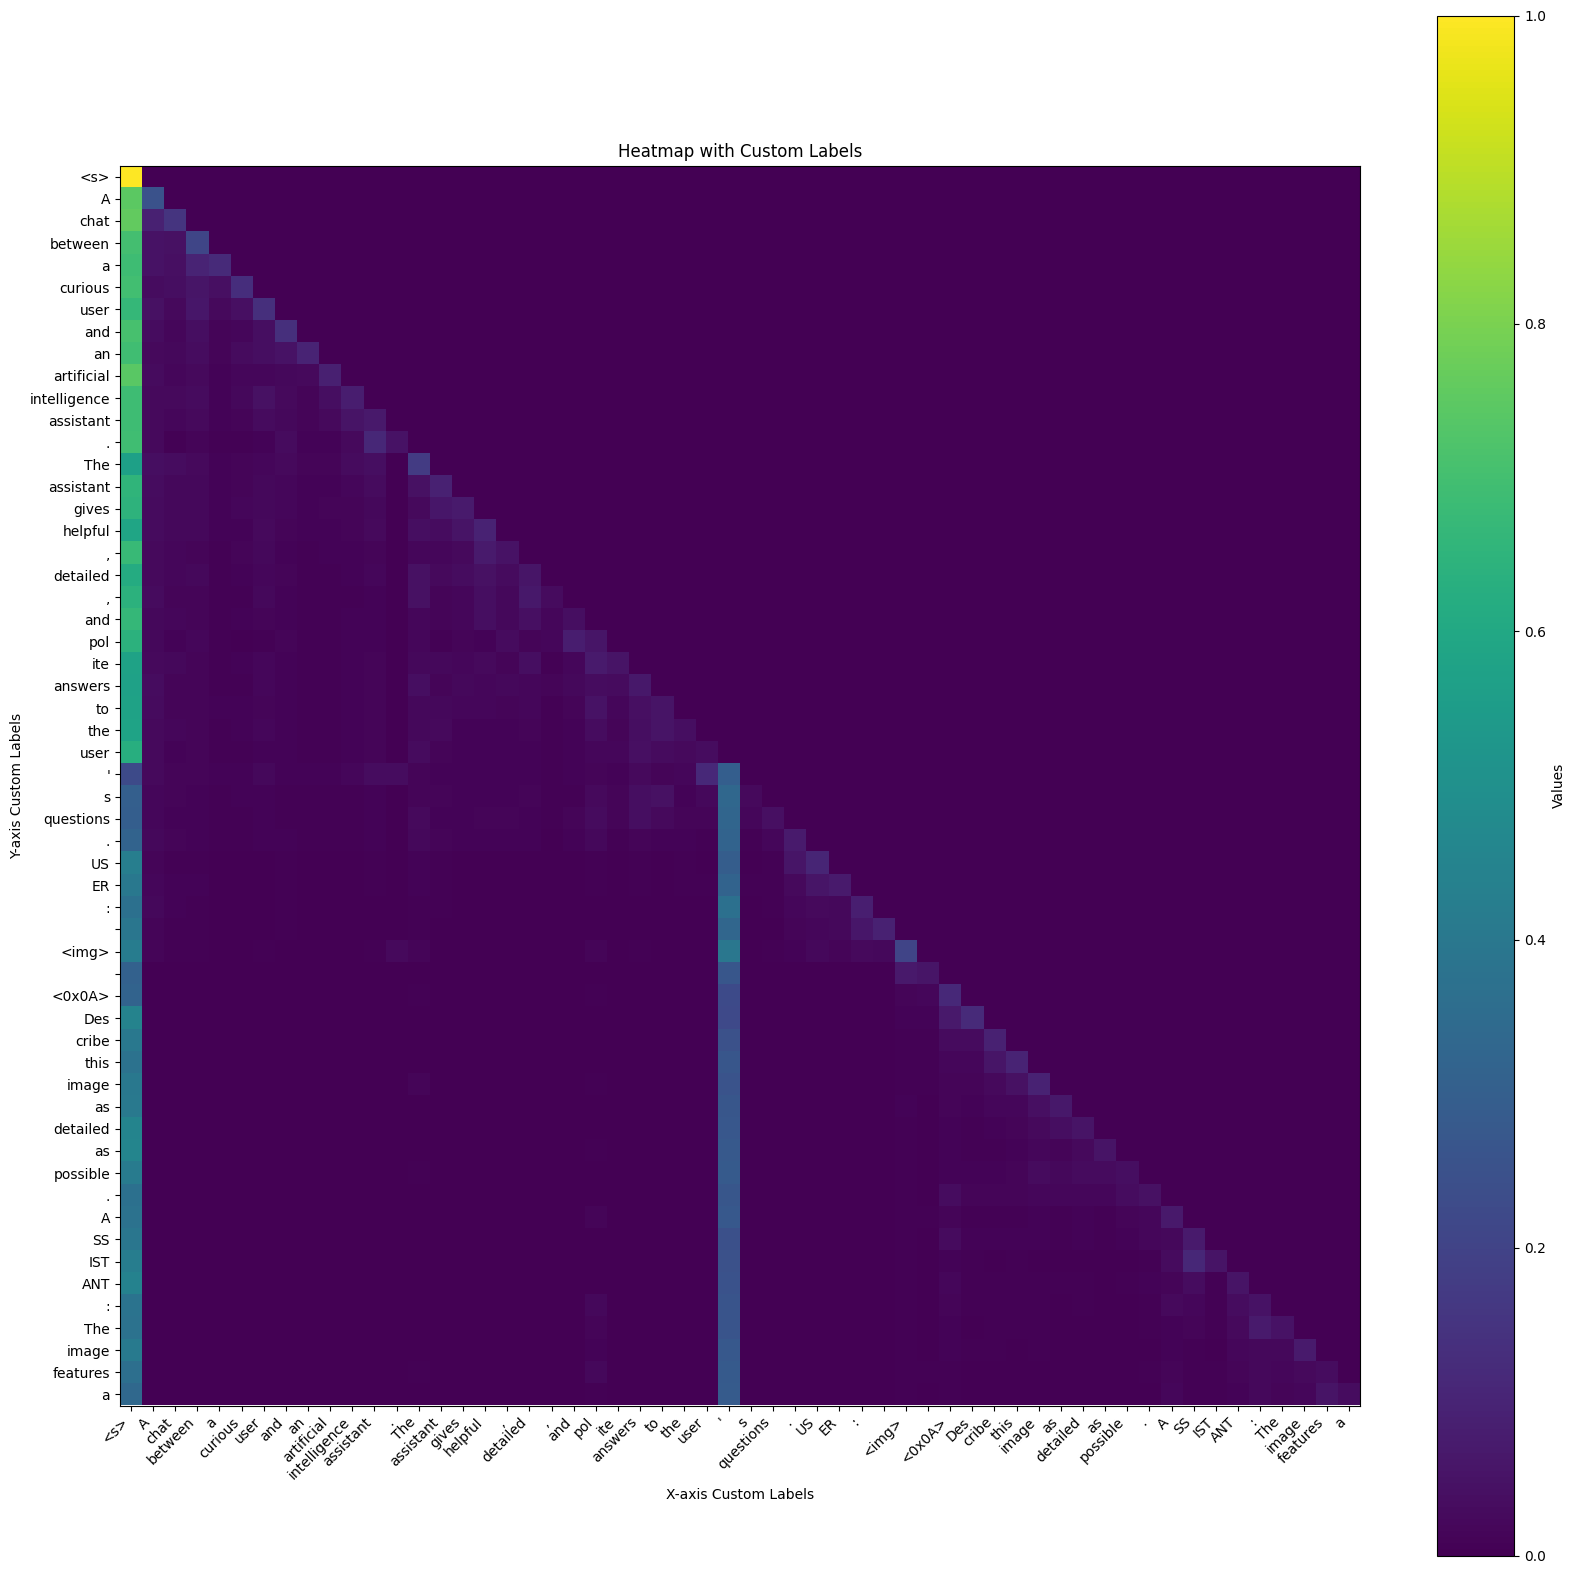

In [180]:
matrix = new_matrix
x_labels= charactor_lst
y_labels= charactor_lst

# 可视化热力图
plt.figure(figsize=(20, 20))           # 设置画布大小
plt.imshow(matrix, cmap='viridis')    # 使用 imshow 创建热力图，选择一个颜色映射，比如 'viridis'

plt.xticks(ticks=np.arange(len(x_labels)), labels=x_labels,  rotation=45, ha='right')
plt.yticks(ticks=np.arange(len(y_labels)), labels=y_labels)

# 添加标题和颜色条
plt.title("Heatmap with Custom Labels")
plt.colorbar(label='Values')  # 添加颜色条
plt.xlabel("X-axis Custom Labels")
plt.ylabel("Y-axis Custom Labels")

# 显示热力图
plt.show()

In [181]:
img_emb_len = 576
img_col = mean_attn[sys_len:sys_len+img_emb_len,:] # (576, 761)
ans_col = mean_attn[sys_len+img_emb_len: , :] #  (150, 761)
mean_img_col = np.mean(img_col, axis=0, keepdims=True)
new_col = np.vstack([mean_img_col, ans_col])
print(img_col.shape, ans_col.shape, mean_img_col.shape, new_col.shape)

img_line = new_col[:, sys_len:sys_len+img_emb_len]
ans_line = new_col[:, sys_len+img_emb_len:]
mean_img_line = np.mean(img_line, axis=1, keepdims=True)
new_matrix = np.hstack([mean_img_line, ans_line])
print(img_line.shape, ans_line.shape, mean_img_line.shape, new_matrix.shape)

(576, 761) (150, 761) (1, 761) (151, 761)
(151, 576) (151, 150) (151, 1) (151, 151)


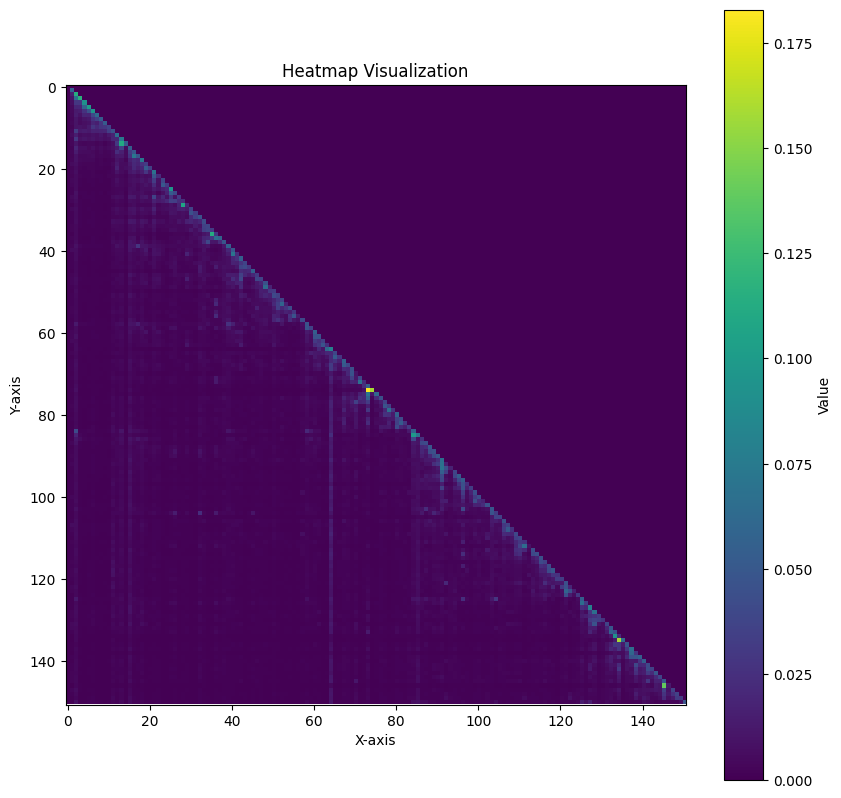

In [182]:
matrix = new_matrix

# 可视化热力图
plt.figure(figsize=(10, 10))           # 设置画布大小
plt.imshow(matrix, cmap='viridis')    # 使用 imshow 创建热力图，选择一个颜色映射，比如 'viridis'
plt.colorbar(label="Value")           # 添加颜色条，表示矩阵值的范围和意义
plt.title("Heatmap Visualization")    # 添加标题
plt.xlabel("X-axis")                  # 添加 X 轴标签
plt.ylabel("Y-axis")                  # 添加 Y 轴标签
plt.show()                            # 显示热力图

In [270]:
tmp_ans_len = 39
img_col = mean_attn[sys_len:sys_len+img_emb_len,:] # (576, 761)
ans_col = mean_attn[sys_len+img_emb_len: sys_len+img_emb_len+tmp_ans_len, :] #  (150, 761)
# mean_img_col = np.mean(img_col, axis=0, keepdims=True)
mean_img_col = np.max(img_col, axis=0, keepdims=True)
new_col = np.vstack([mean_img_col, ans_col])
print(img_col.shape, ans_col.shape, mean_img_col.shape, new_col.shape)

img_line = new_col[:, sys_len:sys_len+img_emb_len]
ans_line = new_col[:, sys_len+img_emb_len:sys_len+img_emb_len+tmp_ans_len]
# mean_img_line = np.mean(img_line, axis=1, keepdims=True)
mean_img_line = np.max(img_line, axis=1, keepdims=True)
new_matrix = np.hstack([mean_img_line, ans_line])
print(img_line.shape, ans_line.shape, mean_img_line.shape, new_matrix.shape)

# \nDescribe this image as detailed as possible. ASSISTANT: The image features a man wearing a red helmet and riding a motorcycle on a dirt road. He
tmp = output_ids[sys_len+1:sys_len+1+tmp_ans_len]
tmp_ans_text = tokenizer.decode(tmp)

charactor_lst = ['<img>'] + [tokenizer.decode(_) for _ in tmp]
print(len(charactor_lst))
print(tmp_ans_text)

(576, 761) (39, 761) (1, 761) (40, 761)
(40, 576) (40, 39) (40, 1) (40, 40)
40

Describe this image as detailed as possible. ASSISTANT: The image features a man wearing a red helmet and riding a motorcycle on a dirt road.


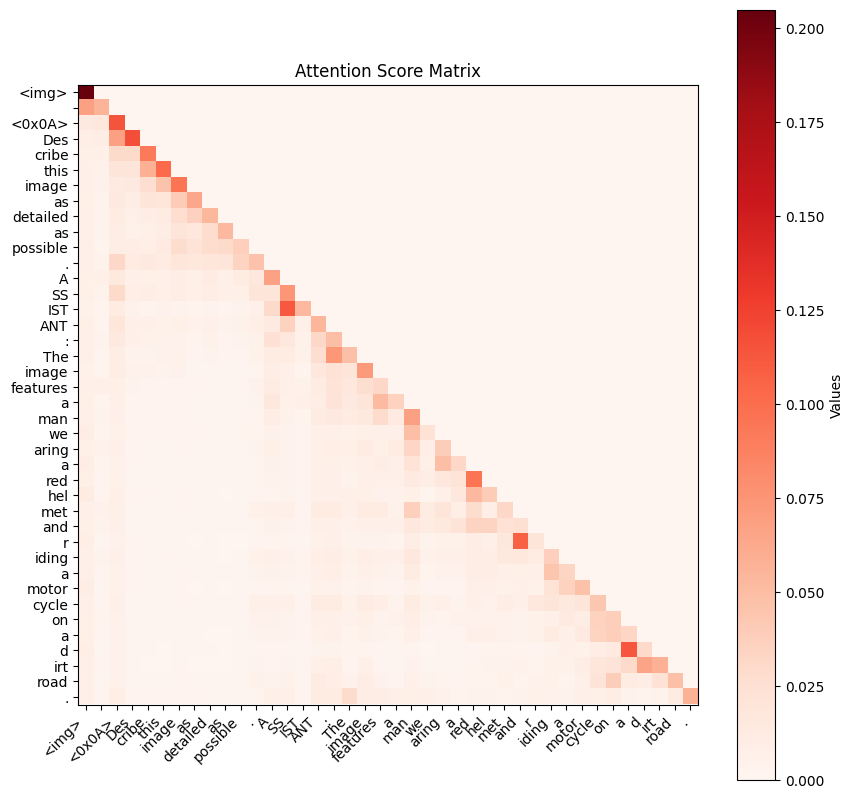

In [272]:
matrix = new_matrix
x_labels= charactor_lst
y_labels= charactor_lst

# 可视化热力图
plt.figure(figsize=(10, 10))           # 设置画布大小
plt.imshow(matrix, cmap='Reds')    # 使用 imshow 创建热力图，选择一个颜色映射，比如 'viridis'

plt.xticks(ticks=np.arange(len(x_labels)), labels=x_labels,  rotation=45, ha='right')
plt.yticks(ticks=np.arange(len(y_labels)), labels=y_labels)

# 添加标题和颜色条
plt.title("Attention Score Matrix")
plt.colorbar(label='Values')  # 添加颜色条
# plt.xlabel("X-axis Custom Labels")
# plt.ylabel("Y-axis Custom Labels")

# 显示热力图
plt.show()

(576, 761) (150, 761) (1, 761) (151, 761)
(151, 576) (151, 150) (151, 1) (151, 151)
150

Describe this image as detailed as possible. ASSISTANT: The image features a man wearing a red helmet and riding a motorcycle on a dirt road. He is sitting on the motorcycle, which is parked on the side of the road. The man appears to be enjoying his ride, possibly exploring the countryside or taking a break from his journey.

There are several other people in the scene, some of them standing or walking nearby. A backpack can be seen placed on the ground, possibly belonging to one of the people in the area. The overall atmosphere of the scene suggests a leisurely outdoor activity or a group of friends spending time together.


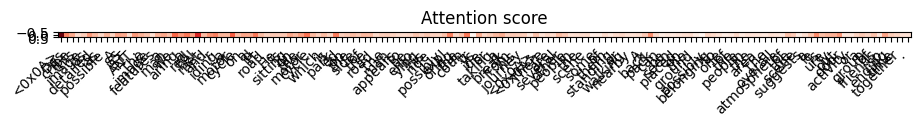

In [259]:
tmp_ans_len = 150
img_col = mean_attn[sys_len:sys_len+img_emb_len,:] # (576, 761)
ans_col = mean_attn[sys_len+img_emb_len: sys_len+img_emb_len+tmp_ans_len, :] #  (150, 761)
mean_img_col = np.max(img_col, axis=0, keepdims=True)
new_col = np.vstack([mean_img_col, ans_col])
print(img_col.shape, ans_col.shape, mean_img_col.shape, new_col.shape)

img_line = new_col[:, sys_len:sys_len+img_emb_len]
ans_line = new_col[:, sys_len+img_emb_len:sys_len+img_emb_len+tmp_ans_len]
mean_img_line = np.max(img_line, axis=1, keepdims=True)
new_matrix = np.hstack([mean_img_line, ans_line])
print(img_line.shape, ans_line.shape, mean_img_line.shape, new_matrix.shape)

tmp = output_ids[sys_len+1:sys_len+1+tmp_ans_len]
tmp_ans_text = tokenizer.decode(tmp)

charactor_lst = [tokenizer.decode(_) for _ in tmp]
print(len(charactor_lst))
print(tmp_ans_text)

matrix = new_matrix[2:,0].reshape(1, -1)
x_labels= [tokenizer.decode(_) for _ in tmp[1:]]

# 可视化热力图
plt.figure(figsize=(11, 11))           # 设置画布大小
plt.imshow(matrix, cmap='Reds')    # 使用 imshow 创建热力图，选择一个颜色映射，比如 'viridis'
plt.xticks(ticks=np.arange(len(x_labels)), labels=x_labels,  rotation=45, ha='right')
plt.title("Attention score")
plt.show()

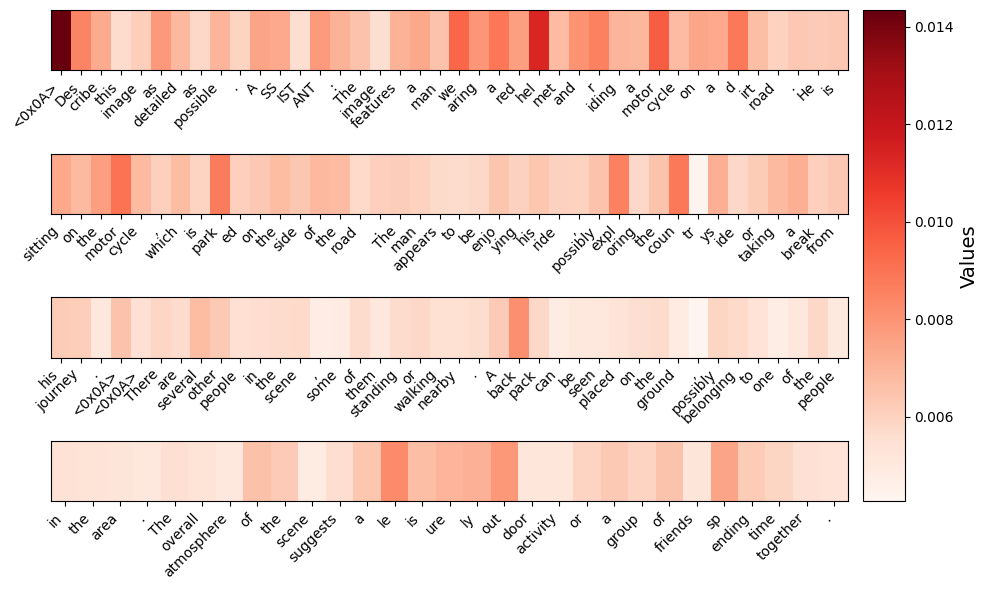

<Figure size 640x480 with 0 Axes>

In [264]:
from matplotlib.gridspec import GridSpec

# 设置每块显示的列数
chunk_size = 40  # 每个子图显示数据的列数
num_chunks = int(np.ceil(matrix.shape[1] / chunk_size))  # 子图数量

# 全局颜色深浅映射范围
vmin = matrix.min()
vmax = matrix.max()

# 定义 GridSpec 布局
fig = plt.figure(figsize=(10, 1.5 * num_chunks))  # 动态画布大小（宽高自适应）
gs = GridSpec(num_chunks, 2, width_ratios=[0.95, 0.05], figure=fig)  # 95% 主图，5% 颜色条

# 创建主图子图
axs = []
for i in range(num_chunks):
    ax = fig.add_subplot(gs[i, 0])  # 主图占用左格
    axs.append(ax)

# 创建颜色条的轴
cbar_ax = fig.add_subplot(gs[:, 1])  # 最右侧全局颜色条

# 绘制每个子图
for i in range(num_chunks):
    start = i * chunk_size
    end = min((i + 1) * chunk_size, matrix.shape[1])  # 子图切片范围

    # 切分矩阵和 x 轴标签
    sub_matrix = matrix[:, start:end]  # 分段矩阵
    sub_x_labels = x_labels[start:end]  # 对应的分段标签

    # 绘制热力图
    im = axs[i].imshow(sub_matrix, cmap='Reds', aspect="auto", vmin=vmin, vmax=vmax)  # 统一 vmin/vmax
    axs[i].set_xticks(np.arange(len(sub_x_labels)))
    axs[i].set_xticklabels(sub_x_labels, rotation=45, ha='right', fontsize=10)  # 设置标签
    # axs[i].set_title(f"Matrix Chunk {i + 1}", fontsize=12)
    axs[i].tick_params(axis='y', left=False, labelleft=False)  # 隐藏 y 轴刻度

# 添加全局颜色条
cbar = fig.colorbar(im, cax=cbar_ax, orientation='vertical')
cbar.set_label('Values', fontsize=14)  # 为颜色条添加文字标签

# 调整整体布局
plt.tight_layout()
plt.show()

import os
plt.savefig(os.path.join(path, "attention_score_img_text.jpg"))

In [92]:
tmp = output_ids[sys_len+2:]
tokenizer.decode(tmp)

'\nDescribe this image as detailed as possible. ASSISTANT: The image features a man wearing a red helmet and riding a motorcycle on a dirt road. He is sitting on the motorcycle, which is parked on the side of the road. The man appears to be enjoying his ride, possibly exploring the countryside or taking a break from his journey.\n\nThere are several other people in the scene, some of them standing or walking nearby. A backpack can be seen placed on the ground, possibly belonging to one of the people in the area. The overall atmosphere of the scene suggests a leisurely outdoor activity or a group of friends spending time together.</s>'

In [ ]:
# np.save('/home/whz/code/HallE/llava/visual_attn/test1_input_ids.npy', input_ids.cpu().numpy())
# np.save('/home/whz/code/HallE/llava/visual_attn/test1_output_ids.npy', generated_ids.cpu().numpy())
# np.save('/home/whz/code/HallE/llava/visual_attn/test1_attn.npy', last_attn.to(torch.float32).numpy())